# Project 4 - Advanced Lane Finding

### Goals:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Main Imports

In [1]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip

%matplotlib inline

## Chessboard Camera Calibration

#### Parameters

In [2]:
NX = 9
NY = 6
CHESSBOARD_DIR = '.\\camera_cal\\*.jpg'

#### Functions

In [3]:
def chessboard_get_corners(imgs, nx, ny):
    """Return image and object points from set of chessboard images."""
    if not isinstance(imgs, list):
        raise ValueError("imgs parameters needs to be a list.")
    # Initialize 3D object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    imgps = []
    objps = []
    for img in imgs:
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect chessboard corners
        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if not found:
            continue
        imgps.append(corners)
        objps.append(objp)
    return imgps, objps

def chessboard_cam_calib(imgps, objps, img_size):
    """Returns camera calibration matrix and distortion coefficients"""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objps, imgps, img_size, None, None)
    return mtx, dist

#### Main

Output each image with superimposed corners and an undistorted version. 

**If unable to find corners for image, then output image in figure without any modification.**

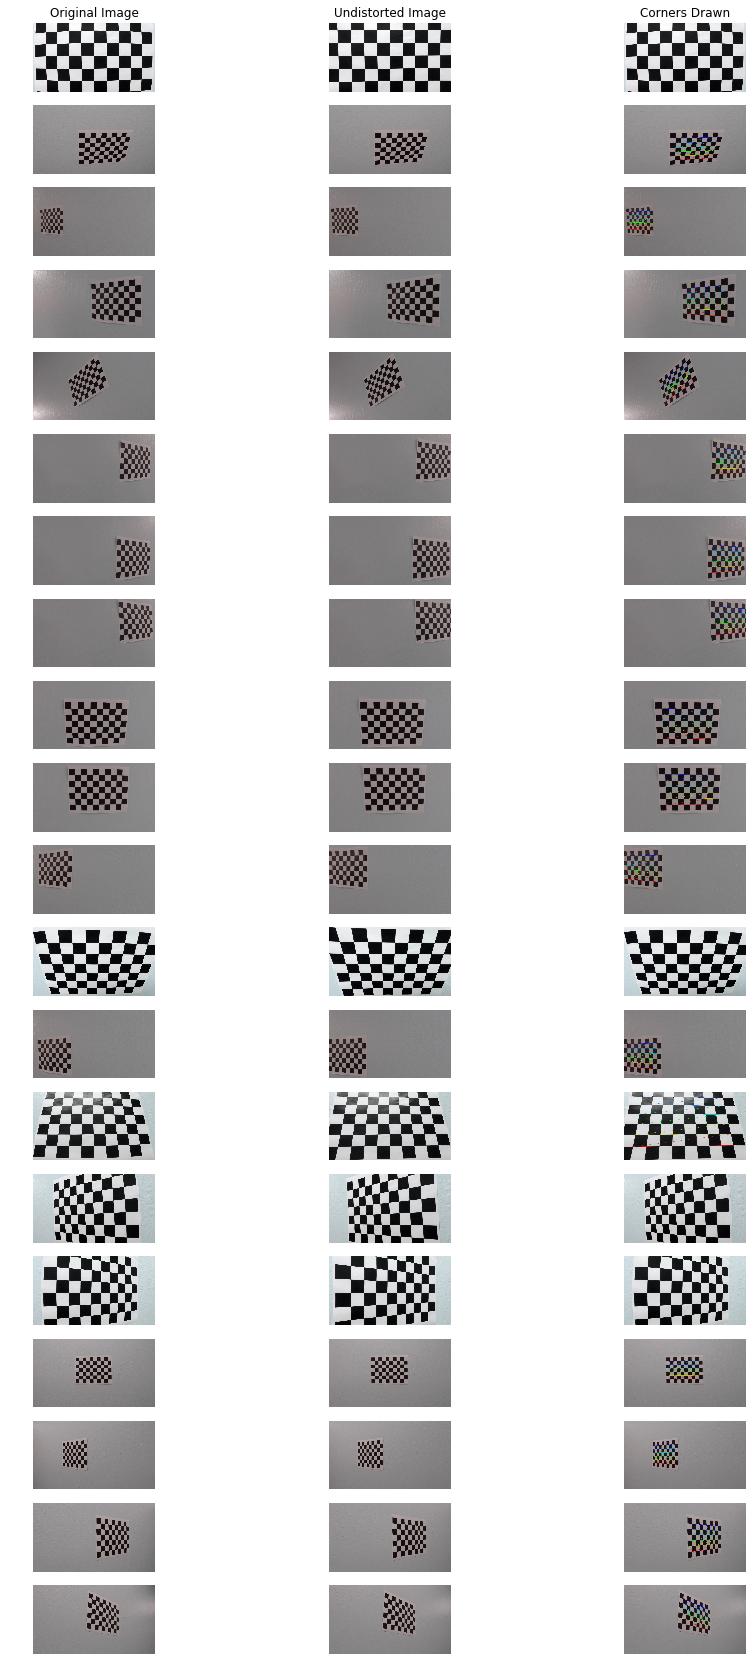

In [4]:
# Retrieve path to all chessboard images
img_locs = glob.glob(CHESSBOARD_DIR)

# Read all images into a list
imgs = []
for img_loc in img_locs:
    img = cv2.imread(img_loc)
    imgs.append(img)
    
# Get size of images using one image as a sample, with width as first element
img_size = imgs[0].shape[::-1][1:]

# Calibrate camera and retrieve calibration matrix and distortion coeddicients
imgps, objps = chessboard_get_corners(imgs, NX, NY)
MTX, DIST = chessboard_cam_calib(imgps, objps, img_size)

# Set up figure for plotting
f, axarr = plt.subplots(len(imgs), 3)
f.set_size_inches(15, 30)

# Loop through images, undistory them, and draw corners on undistorted versions.
for i, img in enumerate(imgs):
    # Set column headings on figure
    if i == 0:
        axarr[i, 0].set_title("Original Image")
        axarr[i, 1].set_title("Undistorted Image")
        axarr[i, 2].set_title("Corners Drawn")
        
    # Generate new undistorted image
    undist = cv2.undistort(img, MTX, DIST, None, MTX)
    # Generate new image with corner points drawn
    undist_copy = undist.copy()
    undist_grey = cv2.cvtColor(undist_copy, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(undist_grey, (NX, NY), None)
    if found:
        drawn = cv2.drawChessboardCorners(undist_copy, (NX, NY), corners, found)
    else:
        drawn = img
    
    # Plot images on figure
    axarr[i, 0].imshow(img)
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(undist)
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(drawn)
    axarr[i, 2].axis('off')

## Lane Driving Pipeline

### Distortion Corrected Image

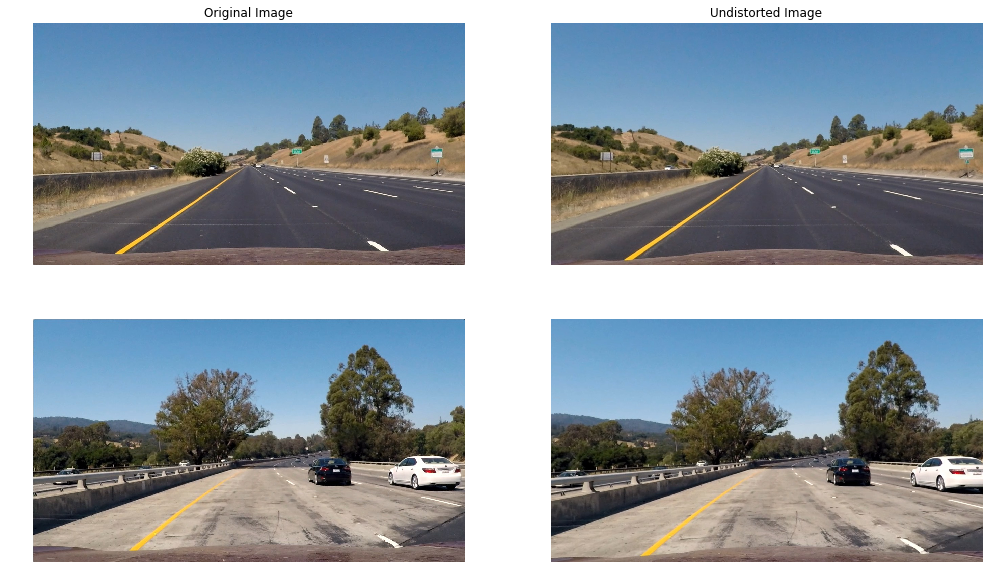

In [5]:
if not "MTX" in globals():
    raise ValueError("Please run Main section above to generate required camera calibration coefficients.")

TEST_IMG = ".\\test_images\\straight_lines1.jpg"
lane_test_img = cv2.imread(TEST_IMG)
lane_test_img_rgb = cv2.cvtColor(lane_test_img, cv2.COLOR_BGR2RGB)
lane_test_undist = cv2.undistort(lane_test_img_rgb, MTX, DIST, None, MTX)

TEST_IMG2 = ".\\test_images\\test1.jpg"
lane_test_img2 = cv2.imread(TEST_IMG2)
lane_test_img2_rgb = cv2.cvtColor(lane_test_img2, cv2.COLOR_BGR2RGB)
lane_test_undist2 = cv2.undistort(lane_test_img2_rgb, MTX, DIST, None, MTX)

f, axarr = plt.subplots(2,2)
f.set_size_inches(17, 10)
axarr[0, 0].imshow(lane_test_img_rgb)
axarr[0, 1].imshow(lane_test_undist)
axarr[0, 0].set_title("Original Image")
axarr[0, 1].set_title("Undistorted Image")
axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[1, 0].imshow(lane_test_img2_rgb)
axarr[1, 1].imshow(lane_test_undist2)
axarr[1, 0].axis('off')
axarr[1, 1].axis('off');

### Threshold Binary Image

To generate a binary image, S channel and gradient thresholding has been used.

#### Parameters

In [6]:
GRADIENT_THRESH = (20, 100)
S_CHANNEL_THRESH = (80, 255)
L_CHANNEL_THRESH = (80, 255)
B_CHANNEL_THRESH = (150, 200)
L2_CHANNEL_THRESH = (225, 255)

#### Functions

In [7]:
def seperate_hls(rgb_img):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    return h, l, s

def seperate_lab(rgb_img):
    lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    return l, a, b

def seperate_luv(rgb_img):
    luv = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2Luv)
    l = luv[:,:,0]
    u = luv[:,:,1]
    v = luv[:,:,2]
    return l, u, v

def binary_threshold_lab_luv(rgb_img, bthresh, lthresh):
    l, a, b = seperate_lab(rgb_img)
    l2, u, v = seperate_luv(rgb_img)
    binary = np.zeros_like(l)
    binary[
        ((b > bthresh[0]) & (b <= bthresh[1])) |
        ((l2 > lthresh[0]) & (l2 <= lthresh[1]))
    ] = 1
    return binary

def binary_threshold_hls(rgb_img, sthresh, lthresh):
    h, l, s = seperate_hls(rgb_img)
    binary = np.zeros_like(h)
    binary[
        ((s > sthresh[0]) & (s <= sthresh[1])) &
        ((l > lthresh[0]) & (l <= lthresh[1]))
    ] = 1
    return binary

def gradient_threshold(channel, thresh):
    # Take the derivative in x
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold gradient channel
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

#### Main

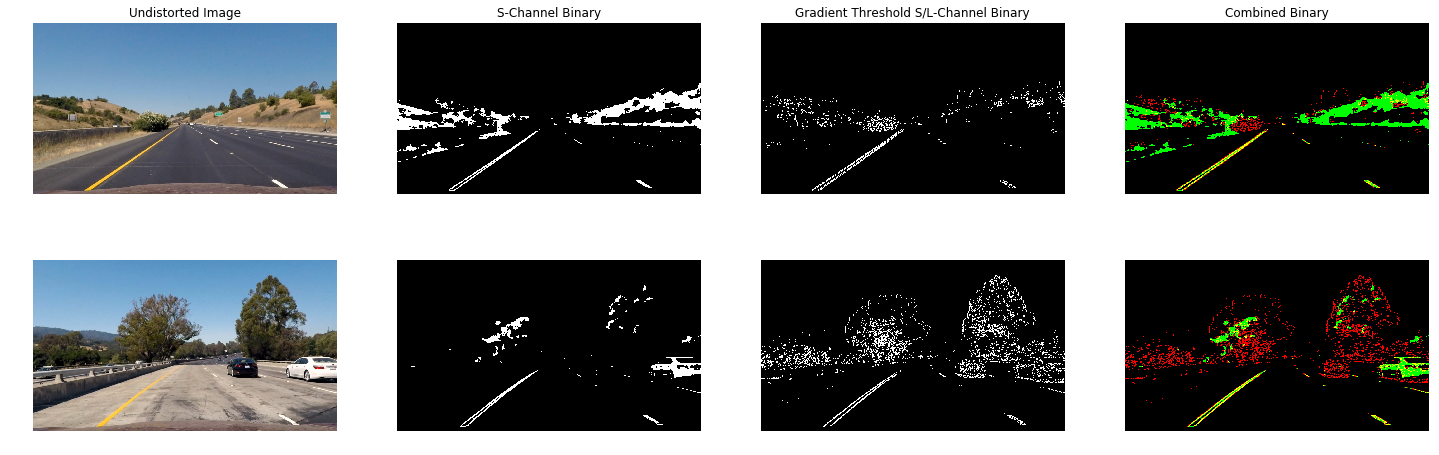

In [8]:
# LAB and LUV channel threshold
s_binary = binary_threshold_lab_luv(lane_test_undist, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
s_binary2 = binary_threshold_lab_luv(lane_test_undist2, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)

# Gradient threshold on S channel
h, l, s = seperate_hls(lane_test_undist)
sxbinary = gradient_threshold(s, GRADIENT_THRESH)

h2, l2, s2 = seperate_hls(lane_test_undist2)
sxbinary2 = gradient_threshold(s2, GRADIENT_THRESH)

# Combine two binary images to view their contribution in green and red
color_binary = np.dstack((sxbinary, s_binary, np.zeros_like(sxbinary))) * 255
color_binary2 = np.dstack((sxbinary2, s_binary2, np.zeros_like(sxbinary2))) * 255

# Draw figure for binary images
f, axarr = plt.subplots(2,4)
f.set_size_inches(25, 8)
axarr[0, 0].imshow(lane_test_undist)
axarr[0, 1].imshow(s_binary, cmap='gray')
axarr[0, 2].imshow(sxbinary, cmap='gray')
axarr[0, 3].imshow(color_binary)
axarr[0, 0].set_title("Undistorted Image")
axarr[0, 1].set_title("B/L Channel Binary")
axarr[0, 2].set_title("Gradient Threshold S/L-Channel Binary")
axarr[0, 3].set_title("Combined Binary")
axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[0, 2].axis('off')
axarr[0, 3].axis('off')
axarr[1, 0].imshow(lane_test_undist2)
axarr[1, 1].imshow(s_binary2, cmap='gray')
axarr[1, 2].imshow(sxbinary2, cmap='gray')
axarr[1, 3].imshow(color_binary2)
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')
axarr[1, 2].axis('off')
axarr[1, 3].axis('off');

### Prespective Transform

#### Parameters

In [9]:
IMG_SIZE = lane_test_undist.shape[::-1][1:]
OFFSET = 300

PRES_SRC_PNTS = np.float32([
    (596, 447), # Top-left corner
    (190, 720), # Bottom-left corner
    (1125, 720), # Bottom-right corner
    (685, 447) # Top-right corner
])

PRES_DST_PNTS = np.float32([
    [OFFSET, 0], 
    [OFFSET, IMG_SIZE[1]],
    [IMG_SIZE[0]-OFFSET, IMG_SIZE[1]], 
    [IMG_SIZE[0]-OFFSET, 0]
])

#### Main

#### Display chosen source points on sample image

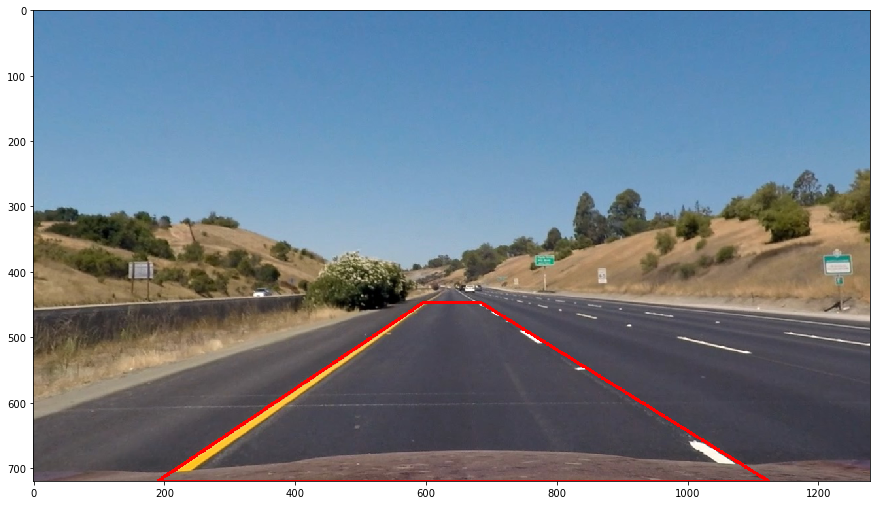

In [10]:
lane_test_undist_cp = lane_test_undist.copy()
plt.figure(figsize = (15, 15))
plt.imshow(cv2.polylines(lane_test_undist_cp, np.int32([PRES_SRC_PNTS]), True, (255,0,0), 3));

#### Perform Perspective Transform
Lines appear parallel in the image as recommended

In [11]:
M = cv2.getPerspectiveTransform(PRES_SRC_PNTS, PRES_DST_PNTS)
M_INV = cv2.getPerspectiveTransform(PRES_DST_PNTS, PRES_SRC_PNTS)
warped = cv2.warpPerspective(lane_test_undist, M, IMG_SIZE, flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(lane_test_undist2, M, IMG_SIZE, flags=cv2.INTER_LINEAR)

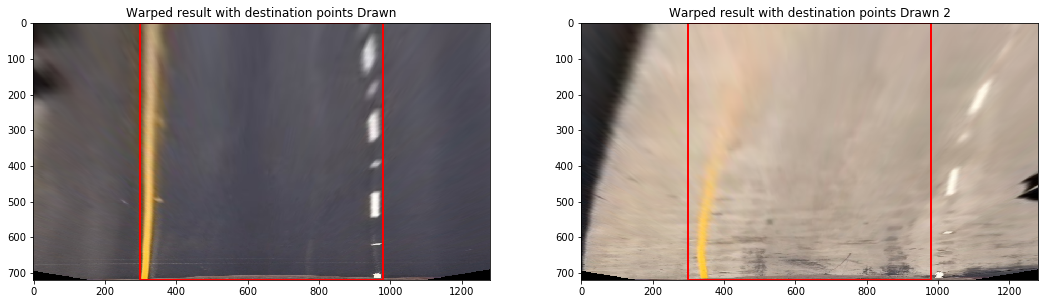

In [12]:
warped_cp = warped.copy()
warped2_cp = warped2.copy()
warped_poly = cv2.polylines(warped_cp, np.int32([PRES_DST_PNTS]), True, (255,0,0), 3)
warped2_poly = cv2.polylines(warped2_cp, np.int32([PRES_DST_PNTS]), True, (255,0,0), 3)

# Draw figure for the two warped lane lines
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(warped_poly)
axarr[1].imshow(warped2_poly)
axarr[0].set_title("Warped result with destination points Drawn")
axarr[1].set_title("Warped result with destination points Drawn 2");

### Lane Line Identification

To confirm that detected lane lines are real, consider:

* Checking that they have similar curvature
* Checking that they are separated by approximately the right distance horizontally
* Checking that they are roughly parallel

#### Parameters

In [13]:
N_WINDOWS = 10
MARGIN = 100
RECENTER_MINPIX = 50

# Define conversions in x and y from pixels space to meters
YM_PER_PIX = 30 / 720 # meters per pixel in y dimension
XM_PER_PIX = 3.7 / 700 # meters per pixel in x dimension

#### Functions

In [14]:
def histo_peak(histo):
    """Find left and right peaks of histogram"""
    midpoint = np.int(histo.shape[0]/2)
    leftx_base = np.argmax(histo[:midpoint])
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_lane_indices_sliding_windows(binary_warped, leftx_base, rightx_base, n_windows, margin, recenter_minpix):
    """Get lane line pixel indices by using sliding window technique"""
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.copy()
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/n_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > recenter_minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > recenter_minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img

def get_lane_indices_from_prev_window(binary_warped_img, left_fit, right_fit, margin):
    """Detect lane line by searching around detection of previous sliding window detection"""
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx

#### Main

#### Display binary warped image and lane pixels histogram

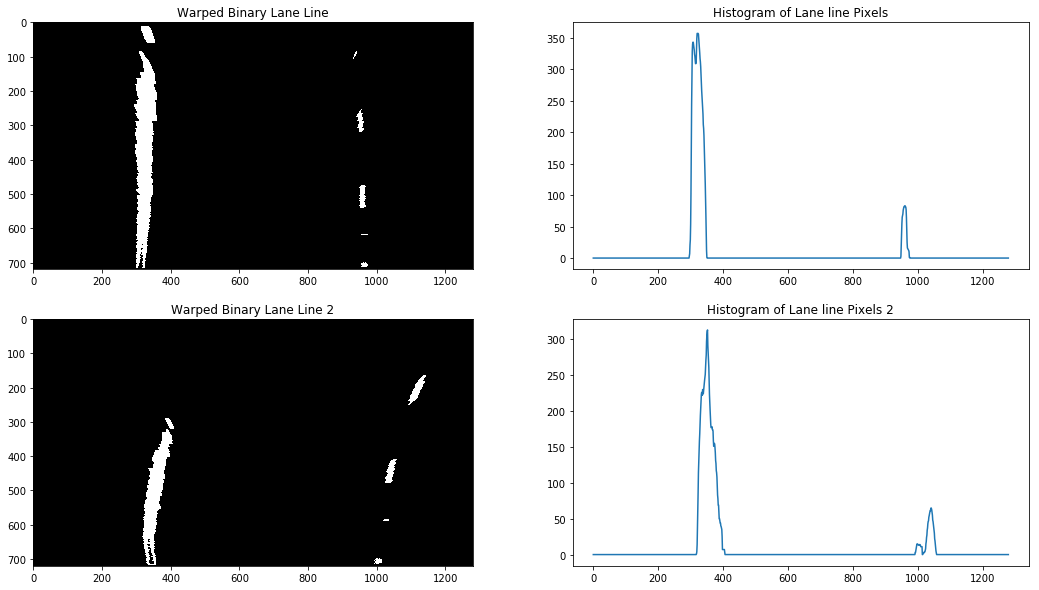

In [15]:
# Warp binary image of lane line
binary_warped = cv2.warpPerspective(s_binary, M, IMG_SIZE, flags=cv2.INTER_LINEAR)
binary_warped2 = cv2.warpPerspective(s_binary2, M, IMG_SIZE, flags=cv2.INTER_LINEAR)

# Calculate histogram of lane line pixels
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
histogram2 = np.sum(binary_warped2[int(binary_warped2.shape[0]/2):,:], axis=0)

# Draw figure for warped binary and histogram
f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0, 0].imshow(binary_warped, cmap='gray')
axarr[0, 1].plot(histogram)
axarr[0, 0].set_title("Warped Binary Lane Line")
axarr[0, 1].set_title("Histogram of Lane line Pixels")
axarr[1, 0].imshow(binary_warped2, cmap='gray')
axarr[1, 1].plot(histogram2)
axarr[1, 0].set_title("Warped Binary Lane Line 2")
axarr[1, 1].set_title("Histogram of Lane line Pixels 2");

#### Locate lane lines using sliding window technique and fit with polynomial

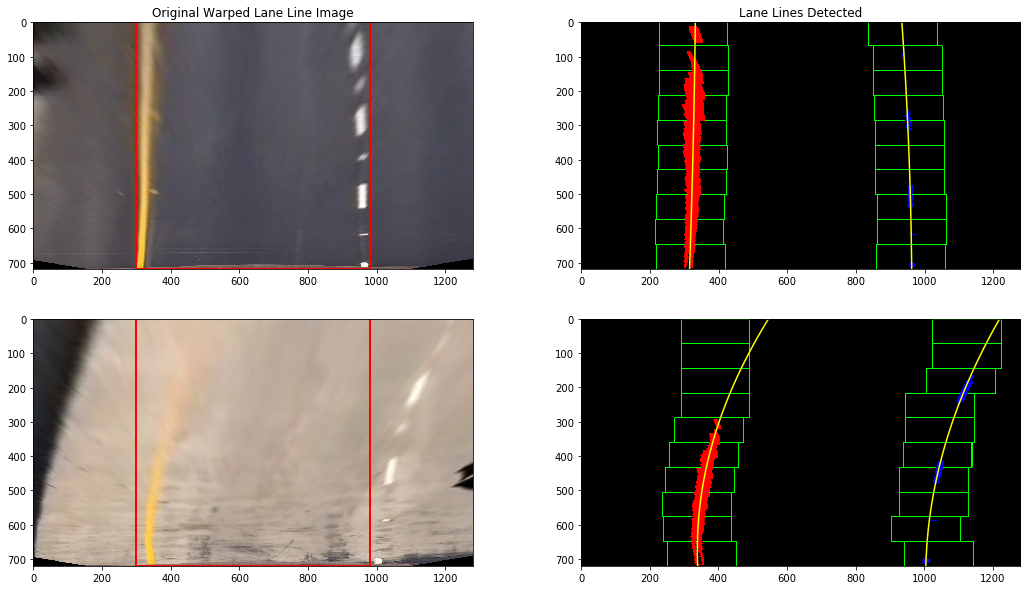

In [16]:
leftx_base, rightx_base = histo_peak(histogram)
left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
    binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX)

leftx_base2, rightx_base2 = histo_peak(histogram2)
left_lane_inds2, right_lane_inds2, nonzerox2, nonzeroy2, out_img2 = get_lane_indices_sliding_windows(
    binary_warped2, leftx_base2, rightx_base2, N_WINDOWS, MARGIN, RECENTER_MINPIX)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

leftx2 = nonzerox2[left_lane_inds2]
lefty2 = nonzeroy2[left_lane_inds2] 
rightx2 = nonzerox2[right_lane_inds2]
righty2 = nonzeroy2[right_lane_inds2] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
left_fit2 = np.polyfit(lefty2, leftx2, 2)
right_fit2 = np.polyfit(righty2, rightx2, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

ploty2 = np.linspace(0, binary_warped2.shape[0]-1, binary_warped2.shape[0] )
left_fitx2 = left_fit2[0]*ploty2**2 + left_fit2[1]*ploty2 + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty2**2 + right_fit2[1]*ploty2 + right_fit2[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
out_img2[nonzeroy2[left_lane_inds2], nonzerox2[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy2[right_lane_inds2], nonzerox2[right_lane_inds2]] = [0, 0, 255]

# Draw figures of line lanes detected
f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0, 0].imshow(warped_cp)
axarr[0, 1].imshow(out_img)
axarr[0, 1].plot(left_fitx, ploty, color='yellow')
axarr[0, 1].plot(right_fitx, ploty, color='yellow')
axarr[0, 0].set_title("Original Warped Lane Line Image")
axarr[0, 1].set_title("Lane Lines Detected");
axarr[1, 0].imshow(warped2_cp)
axarr[1, 1].plot(left_fitx2, ploty2, color='yellow')
axarr[1, 1].plot(right_fitx2, ploty2, color='yellow')
axarr[1, 1].imshow(out_img2)
plt.xlim(0, 1280)
plt.ylim(720, 0);

#### Find lane line once sliding window technique is used

In [17]:
left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx = get_lane_indices_from_prev_window(
    binary_warped, left_fit, right_fit, MARGIN)

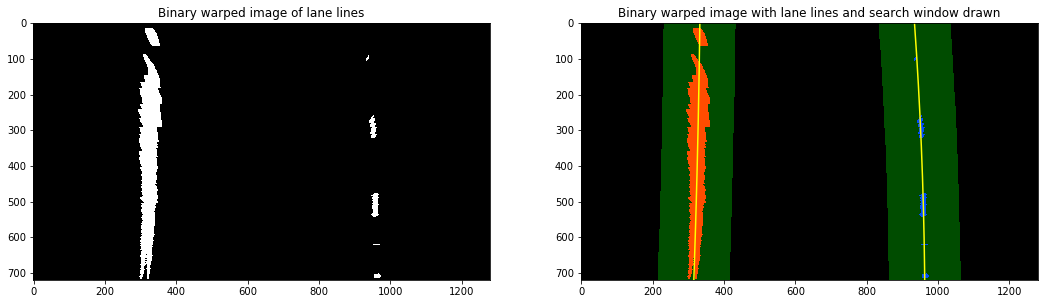

In [18]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-MARGIN, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+MARGIN, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-MARGIN, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+MARGIN, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the figure
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(binary_warped, cmap='gray')
axarr[1].imshow(result)
axarr[1].plot(left_fitx, ploty, color='yellow')
axarr[1].plot(right_fitx, ploty, color='yellow')
axarr[0].set_title("Binary warped image of lane lines")
axarr[1].set_title("Binary warped image with lane lines and search window drawn");

#### Project detected lines onto original image

#### Functions

In [19]:
def project_lane_line(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

#### Main

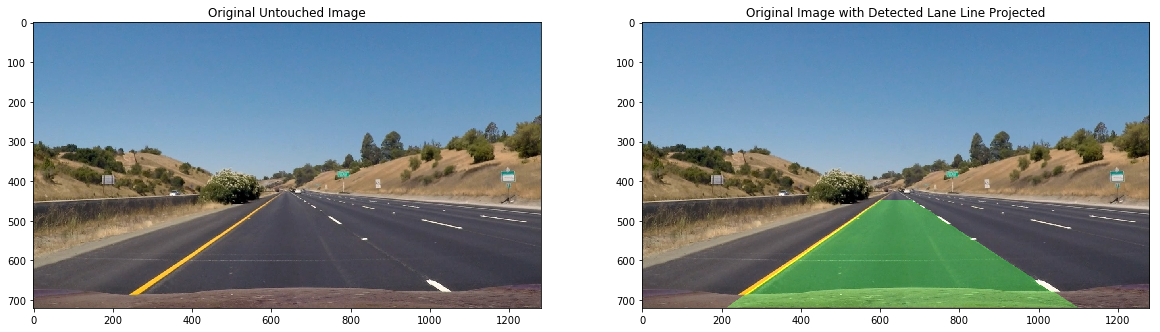

In [20]:
result = project_lane_line(lane_test_img_rgb, binary_warped, ploty, left_fitx, right_fitx, M_INV)

# Plot original image and original image with lane line projected
f, axarr = plt.subplots(1,2)
f.set_size_inches(20, 8)
axarr[0].imshow(lane_test_img_rgb, cmap='gray')
axarr[1].imshow(result)
axarr[0].set_title("Original Untouched Image")
axarr[1].set_title("Original Image with Detected Lane Line Projected");

#### Calculate Curvature of lane lines and center offset

#### Functions

In [21]:
def calc_curvature(ploty, leftx, rightx, lefty, righty, unit="m"):
    """returns curvature in meters."""
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*YM_PER_PIX, leftx*XM_PER_PIX, 2)
    right_fit_cr = np.polyfit(righty*YM_PER_PIX, rightx*XM_PER_PIX, 2)
    # Calculate the new radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[0]*y_eval*YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curvem, right_curvem

def calc_car_pos(img, left_fit, right_fit):
    # Assuming camera is centered in the image, return position of car in cms.
    car_loc = img.shape[1] / 2

    # Find lane line bottom x-corrdinate
    height = img.shape[0]
    bottom_left = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    bottom_right = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]

    center_lane = (bottom_right - bottom_left)/2 + bottom_left 
    center_offset = ( np.abs(car_loc) - np.abs(center_lane)) * XM_PER_PIX * 100
    return center_offset

#### Find Radius of Lane Lines (Curvature) for straight lane line image

In [22]:
left_curvem, right_curvem = calc_curvature(ploty2, leftx2, rightx2, lefty2, righty2)
print(left_curvem, 'm', right_curvem, 'm')

357.695767844 m 432.907425591 m


#### Find Radius of Lane Lines (Curvature) for curved lane line image

In [23]:
left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
print(left_curvem, 'm', right_curvem, 'm')

10532.5992844 m 3890.65703814 m


#### Find position of vehicle with respect to center
We assume that the lane is about 30 meters long and 3.7 meters wide.

In [24]:
center_offset = calc_car_pos(lane_test_img_rgb, left_fit, right_fit)
print(str(center_offset) + 'cm')

0.534128179197cm


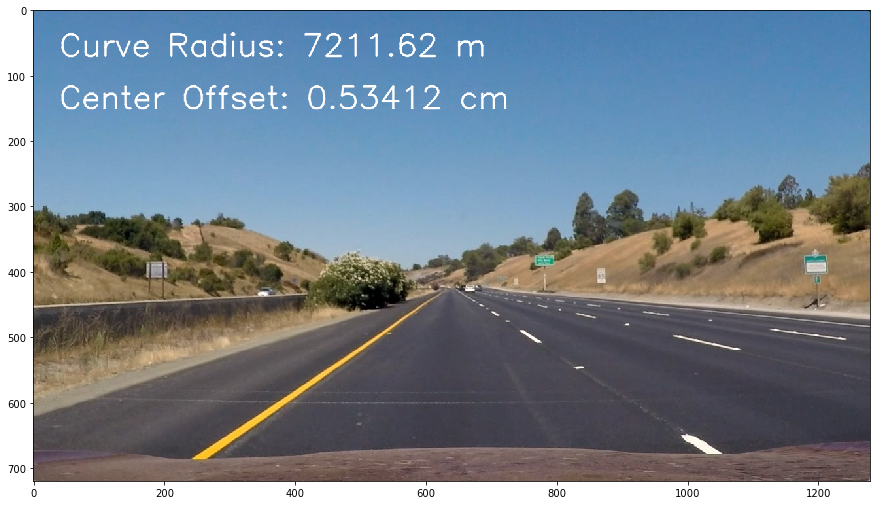

In [25]:
img_cp = lane_test_img_rgb.copy()
cv2.putText(img_cp,'Curve Radius: '+str((left_curvem+right_curvem)/2)[:7]+' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
cv2.putText(img_cp,'Center Offset: '+str(center_offset)[:7]+' cm',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
plt.figure(figsize = (15, 15))
plt.imshow(img_cp)

## Run Pipeline on Video
Use pixels detected as sanity check

#### Parameters

In [26]:
VID_INPUT = "project_video.mp4"
VID_OUT_DIR = ".\\video_results"
VID_OUTPUT_PATH = VID_OUT_DIR + "\\project_video_result.mp4"

CO_THRES = 5
PIXEL_THRES = 600

#### Global Parameters

In [27]:
global_vars = {
    'left_fit': None,
    'right_fit': None,
    'left_fitx': None,
    'right_fitx': None,
    'co': 0
}

#### Functions

In [28]:
class Line():
    """Class to represent the characteristics of each line detection"""
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def run_pipeline(image):
    # Preprocess Image
    image_undist = cv2.undistort(image, MTX, DIST, None, MTX)
    s_binary = binary_threshold_lab_luv(image_undist, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
    binary_warped = cv2.warpPerspective(s_binary, M, IMG_SIZE, flags=cv2.INTER_LINEAR)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Identify Lane Lines using sliding window
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    leftx_base, rightx_base = histo_peak(histogram)
    left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
        binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX
    )
    if len(right_lane_inds) < PIXEL_THRES:
        result = project_lane_line(
            image_undist, binary_warped, ploty, global_vars['left_fitx'], global_vars['right_fitx'], M_INV
        )
    else:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        co = calc_car_pos(image, left_fit, right_fit)
        left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
        result = project_lane_line(image_undist, binary_warped, ploty, left_fitx, right_fitx, M_INV)
        global_vars['left_fitx'] = left_fitx
        global_vars['right_fitx'] = right_fitx
        global_vars['left_curvem'] = left_curvem
        global_vars['right_curvem'] = right_curvem
        global_vars['co'] = co

    cv2.putText(result,'Curve Radius: '+str((global_vars['left_curvem']+global_vars['right_curvem'])/2)[:7]+' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Center Offset: '+str(global_vars['co'])[:7]+' cm',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    return result

#### Main

In [29]:
if not os.path.exists(VID_OUT_DIR):
    os.makedirs(VID_OUT_DIR)

# Process each frame in the project video input and output a new video with lane lines projected
clip = VideoFileClip(VID_INPUT)
new_clip = clip.fl_image(run_pipeline)
new_clip.write_videofile(VID_OUTPUT_PATH, audio=False, verbose=False, progress_bar=False);